### Linear quadratic control

solution to the DARE: [[0.75799122 0.53665112]
 [0.53665112 0.75988856]]


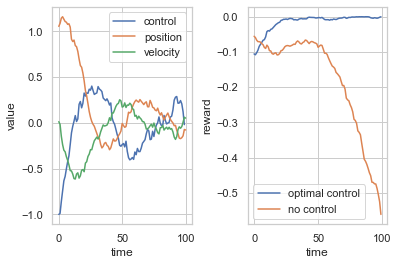

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

from utils import double_integrator

path_out = 'C:\\Users\\u714174\\Data\\neural_control\\figures'

initial_pos = np.array([1, 0])

model = double_integrator(dt=0.1, var_x=10**-2, var_y=0.0, q=0.5, r=0.5, mu0=initial_pos, var0=0.001)

print('solution to the DARE: ' + str(model.S))

T = 10 # simulation length in seconds
N = int(np.floor(T/model.dt)) # nr of simulation steps

# # create infinite horizon model
# model = LQR(_A, _b, _Sigma, _Q, _R, mu0, Sigma0)

# true state
X = np.zeros([model.n_state, N+1])

# control vector
U = np.zeros([model.n_control, N])

# running cost
g = np.zeros(N)

np.random.seed(0)

X[:,0] = model.initial_state()
for n in range(N):

    # compute control
    U[:,n] = model.control(X[:,n])

    # true state dynamics
    X[:,n+1] = model.step(X[:,n], U[:,n])

    # reward
    g[n] = model.reward(X[:,n], U[:,n])

# compare with uncontrolled case

np.random.seed(0)

uX = np.zeros([model.n_state, N+1])
ug = np.zeros(N)
uX[:,0] = model.initial_state()
for n in range(N):
    uX[:,n+1] = model.step(uX[:,n], np.zeros([model.n_control]))
    ug[n] = model.reward(uX[:,n], np.zeros([model.n_control]))

# plt.figure(figsize=(12, 6), dpi=80)

plt.subplot(1,2,1)
plt.plot(U.T)
plt.plot(X.T)
plt.xlabel('time')
plt.ylabel('value')
plt.legend(['control', 'position', 'velocity'])

plt.subplot(1,2,2)
plt.plot(g)
plt.plot(ug)
# plt.title('cost')
plt.xlabel('time')
plt.ylabel('reward')
plt.legend(['optimal control', 'no control'])

plt.subplots_adjust(wspace = 0.4)
# plt.subplots_adjust(bottom=0.1, right=2.8, top=0.9)
# cax = plt.axes([0.85, 0.1, 0.075, 0.8])

# plt.show()

plt.savefig(os.path.join(path_out, 'LQRinfcontrol.jpg'), format='jpg')

### Linear quadratic gaussian control

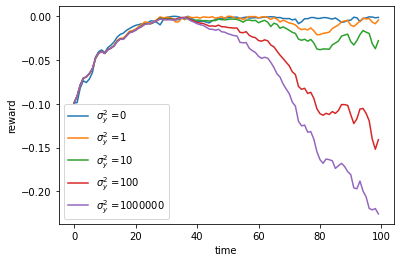

In [2]:
from utils import kalman_filter

n_obs = 1

# observations
Y = np.zeros([model.n_obs, N+1])

# noisy measurement of particle position
C = np.array([[1, 0]])

noise = [0, 1, 10, 100, 10**6] # variance of the noisy observation (low and high noise)
for level in noise:

    np.random.seed(0)

    # V = level * np.eye(1)
    model = double_integrator(dt=0.1, var_x=10**-2, var_y=level, q=0.5, r=0.5, mu0=initial_pos, var0=0.001)
    # model = LQG(_A, _b, _Sigma, _Q, _R, mu0, Sigma0, C, V)

    # state estimate
    mu = np.zeros([model.n_state, N+1])
    Sigma = np.zeros([model.n_state, model.n_state, N+1])

    mu[:,0] = model.mu0
    Sigma[:,:,0] = model.Sigma0

    X[:,0] = model.initial_state()
    for n in range(N):

        # compute control
        U[:,n] = model.control(mu[:,n])

        # true state dynamics
        X[:,n+1] = model.step(X[:,n], U[:,n])
    
        # new observation
        Y[:,n+1] = model.observe(X[:,n+1])

        # update state estimate
        mu[:,n+1], Sigma[:,:,n+1] = kalman_filter(mu[:,n], Sigma[:,:,n], Y[:,n+1], model.A, model.C, model.W, model.V, U[:,n], model.B)

        # reward
        g[n] = model.reward(X[:,n], U[:,n])

    # plt.subplot(1,len(noise),level)
    plt.plot(g)

plt.xlabel('time')
plt.ylabel('reward')
strlevel = []
for level in noise:
    strlevel.append('$\sigma_y^2$ =' + str(level))
plt.legend(strlevel)

# plt.show()

plt.savefig(os.path.join(path_out, 'LQGinfcontrol.jpg'), format='jpg')
